In [1]:
import tensorflow as tf
import numpy as np
import random
import time
import pickle
import os, sys
from fmnist_dataset import Fashion_MNIST
from cnn import CNN
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
def plot_attack_image(x_pred_true, y_pred_true):
    print('plot...')
    samples_per_class = 7
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(7, 10)
    gs.update(wspace=0.035, hspace=0.1)  # set the spacing between axes.
    classes = range(10)
    num_classes = 10
    for y_, cls in enumerate(classes):
        idxs = np.flatnonzero(y_ == np.argmax(y_pred_true, axis=1))  # 1代表行
        idxs = np.random.choice(idxs, samples_per_class, replace=False)  # 随机抽7张该类图片
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y_
            ax = plt.subplot(gs[plt_idx])
            ax.axis('off')
            plt.imshow(x_pred_true[idx].reshape((28, 28)))
            pred = np.argmax(y_pred_true[idx])
            plt.title('pred:' + str(pred))
    plt.show()


In [12]:
np.argmax([[1,2,4],[3,0,2.5]],1)

array([2, 0])

In [70]:
class Attacker(object):
    def __init__(self, model):
        self.model = model
        old = range(10)
        new = list(range(1, 10))
        new.append(0)
        self.old2new = dict(zip(old, new))
        self.alpha = 0.01  # 学习率
        self.old_images_ph = tf.placeholder(np.float32, [None, 28, 28, 1])
        self.adv_images_ph = tf.placeholder(np.float32, [None, 28, 28, 1])
        self.l2_grad = 2 * (self.adv_images_ph - self.old_images_ph)
        self.eps = 0.00001

    def estimated_grad(self,x,target,sess):
        #x:[28,28,1]
        grad_val = np.zeros(x.shape)
        row = grad_val.shape[0]
        col = grad_val.shape[1]
#         print('target',target.shape)
        for i in range(row):
            for j in range(col):
                new_x = x.copy()
                new_x[i,j] += self.eps
                log_pred = self.model.infer_op(sess,np.expand_dims(new_x,0))
                log_pred = log_pred[0]
                m = log_pred.shape[0]
#                 print('log,',log_pred.shape)
                f_h_eps1 = -1*log_pred[list(range(m)),target]
#                 print('f shape:',f_h_eps1.shape)
                new_x = x.copy()
                new_x[i,j] -= self.eps
                log_pred = self.model.infer_op(sess,np.expand_dims(new_x,0))
                log_pred = log_pred[0]
                f_h_eps2 = -1*log_pred[list(range(m)),target]
                grad = (f_h_eps1 - f_h_eps2)/(2*self.eps)
                grad_val[i][j] = grad[0]
#         print('shape:',grad_val.shape)  #(28,28,1)
        return grad_val
    def gen_adv(self, x, label, sess, iterations=10):
        old_image = x.copy()
        label = np.argmax(label)
        target = self.old2new[label]  #target为单个数
        for _ in range(iterations):
            grad_val = self.estimated_grad(x,target,sess)
#             print(grad_val)
            x -= self.alpha * np.sign(grad_val)
            x = np.clip(x, 0., 1.)
        x_adv = x #（28，28，1）
        print('orginal label', label)
        pred = self.model.infer_op(sess, np.expand_dims(old_image, 0))
        pred = pred[0]
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_ori = prob[0]
        pred = self.model.infer_op(sess, np.expand_dims(x_adv, 0))
        pred = np.array(pred)
        #         print(pred.shape)
        pred = pred[0]
        #         print(pred.shape)
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_new = prob[0]
        pred = np.argmax(pred, 1)[0]
        print('now prediction is', pred)

        #         print(prob)
        print('        before   after')
        for i in range(len(prob_ori)):
            print('class {}: {:.2f} \t {:.2f}'.format(i, float(prob_ori[i]), float(prob_new[i])))
        if self.old2new[label] == pred:
            print('attack succeed')
        else:
            print('attack fail')

        print('plot...')
        plt.figure(figsize=(9, 9))
        plt.subplot(2, 1, 1)
        plt.imshow(x_adv.reshape((28, 28)))
        plt.title('new image')

        plt.subplot(2, 1, 2)
        plt.title('original image')
        plt.imshow(old_image.reshape((28, 28)))
        #     plt.gcf().set_size_inches(15, 12)
        plt.show()
        return x_adv
    
    
    def check(self,x,target,sess):
        pred = self.model.infer_op(sess, np.expand_dims(x, 0))
        pred = np.array(pred)
        pred = pred[0]
        pred = np.argmax(pred, 1)[0]
        if target == pred:
            return True
        return False
    
    def gen_adv_fast(self, x, label, sess, iterations=10):
        old_image = x.copy()
        label = np.argmax(label)
        target = self.old2new[label]  #target为scalr
        for _ in range(iterations):
            grad_val = self.estimated_grad(x,target,sess)
            x -= self.alpha * np.sign(grad_val)
            x = np.clip(x, 0., 1.)
            if self.check(x,target,sess):
                return (old_image,x,target,True) #攻击成功
        return (old_image,x,target,False) #攻击失败
    def gen_advs_spe(self, X, Y, sess, iterations=50):
        cnt = 0
        for i in range(X.shape[0]):
            flag = self.gen_adv_fast(X[i], Y[i], sess, iterations)[3]
            if flag:
                cnt += 1
        print('attack success rate:', cnt / X.shape[0])

    def plot_samples(self, samples):
        row_n = len(samples)
        fig = plt.figure(figsize=(16, 16))
        gs = gridspec.GridSpec(7, 10)
        gs.update(wspace=0.035, hspace=0.1)  # set the spacing between axes.
        col_n = 2
        for idx, sample in enumerate(samples):
            plt_idx = col_n * idx
            ax = plt.subplot(gs[plt_idx])
            ax.axis('off')
            plt.imshow(sample[0].reshape(28, 28))
            plt_idx = col_n * idx + 1
            ax = plt.subplot(gs[plt_idx])
            plt.imshow(sample[1].reshape(28, 28))
            ax.axis('off')
            plt.title('class:' + str(int(sample[2])))
        #             print('class :',sample[2])
        plt.show()
    def save_samples(self, samples):
        if not os.path.exists('./white_attack_results'):
            os.mkdir('./white_attack_results')
        root_path = './white_attack_results'
        for idx,sample in enumerate(samples):
            ori_image = sample[0]
            adv_image = sample[1]
            label = sample[2]
            file_path = os.path.join(root_path,'group {},class {},original_img.png'.format(idx,label))
            plt.imsave(file_path,ori_image.reshape(28,28))
            file_path = os.path.join(root_path, 'group {},class {},adversarial_img.png'.format(idx, label))
            plt.imsave(file_path, adv_image.reshape(28, 28))

In [5]:
print("[*] White box attack!", flush=True)
# Load dataset
d = Fashion_MNIST()
# Read hyper-parameters
n_correct = 1000
# correct_path = '../attack_data/correct_1k.pkl'
# model_path = '../model/fmnist_cnn.ckpt'
model_path = '../model/naive_model.ckpt'
dtype = np.float32
# Build model
with tf.variable_scope("fmnist_cnn") as vs:
    m = CNN(scope_name="fmnist_cnn", is_inference=True)
    print("[*] Model built!")
config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
m.restore(sess, model_path)
print("[*] Model loaded!")
print("[*] Model parameters:")
parm_cnt = 0
variable = [v for v in tf.trainable_variables()]
for v in variable:
    print("   ", v.name, v.get_shape())
    parm_cnt_v = 1
    for i in v.get_shape().as_list():
        parm_cnt_v *= i
    parm_cnt += parm_cnt_v
print("[*] Model parameter size: %.4fM" % (parm_cnt / 1024 / 1024))

d.test.reset_epoch()

acc = 0
correct_image = []
correct_label = []
for _iter in range(d.test.size):
    x, y = d.test.next_batch(1, dtype=dtype)
    x = x / 255
    # 如果训练的时候除以了255，那么测试的时候也要做。
    y_hat = m.infer_op(sess, x)
    if (np.argmax(y_hat) == np.argmax(y[0])):
        correct_image.append(x[0])
        correct_label.append(y[0])
        acc += 1
acc /= d.test.size
print("[*] Accuracy on test set: %.5f" % (acc))

_correct_image = []
_correct_label = []

_idx = random.sample(range(len(correct_image)), n_correct)
for i in _idx:
    _correct_image.append(correct_image[i])
    _correct_label.append(correct_label[i])

_correct_image = np.array(_correct_image)
_correct_label = np.array(_correct_label)

x_attack = _correct_image
y_attack = _correct_label

[*] White box attack!
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[*] Model built!
INFO:tensorflow:Restoring parameters from ../model/naive_model.ckpt
[*] Model loaded!
[*] Model parameters:
    fmnist_cnn/Variable:0 (5, 5, 1, 64)
    fmnist_cnn/Variable_1:0 (64,)
    fmnist_cnn/Variable_2:0 (5, 5, 64, 32)
    fmnist_cnn/Variable_3:0 (32,)
    fmnist_cnn/W3:0 (1568, 64)
    fmnist_cnn/Variable_4:0 (64,)
    fmnist_cnn/W4:0 (64, 10)
    fmnist_cnn/Variable_5:0 (10,)
[*] Model parameter size: 0.1468M
[*] Accuracy on test set: 0.91380


plot...


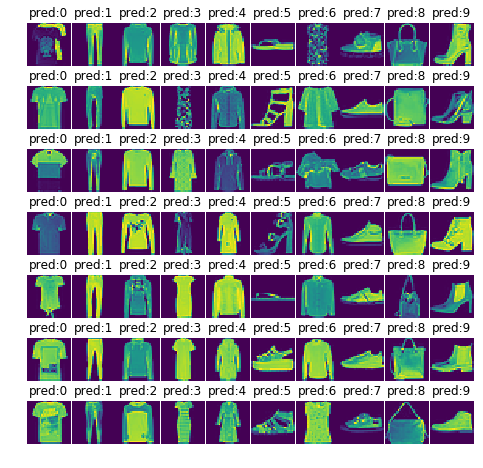

In [6]:
plot_attack_image(x_attack, y_attack)

orginal label 0
now prediction is 1
        before   after
class 0: 0.09 	 0.09
class 1: 0.22 	 0.23
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.09 	 0.09
class 6: 0.09 	 0.09
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack succeed
plot...


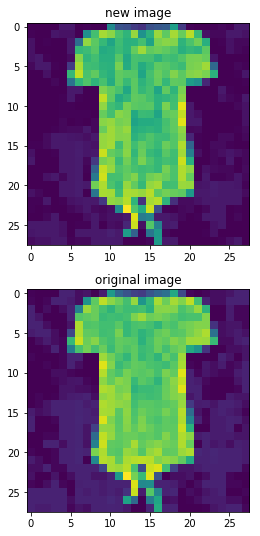

In [72]:
attacker = Attacker(m)
new_image = attacker.gen_adv(x_attack[0],y_attack[0],sess,iterations=3)

orginal label 0
now prediction is 1
        before   after
class 0: 0.13 	 0.09
class 1: 0.16 	 0.23
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.09 	 0.09
class 6: 0.09 	 0.09
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack succeed
plot...


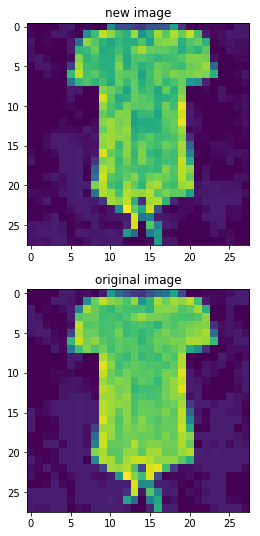

In [65]:
new_image = attacker.gen_adv(x_attack[0],y_attack[0],sess,iterations=5)

orginal label 6
now prediction is 6
        before   after
class 0: 0.14 	 0.12
class 1: 0.09 	 0.09
class 2: 0.09 	 0.10
class 3: 0.09 	 0.10
class 4: 0.09 	 0.09
class 5: 0.09 	 0.09
class 6: 0.15 	 0.14
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack fail
plot...


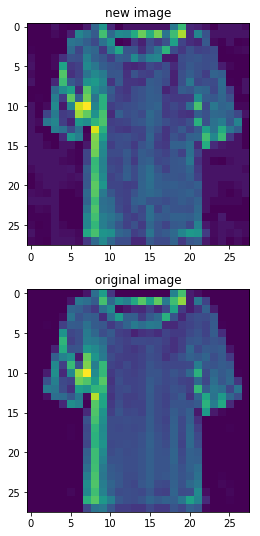

In [67]:
new_image = attacker.gen_adv(x_attack[2],y_attack[2],sess,iterations=5)

orginal label 6
now prediction is 7
        before   after
class 0: 0.13 	 0.09
class 1: 0.09 	 0.09
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.09 	 0.09
class 6: 0.15 	 0.09
class 7: 0.09 	 0.22
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack succeed
plot...


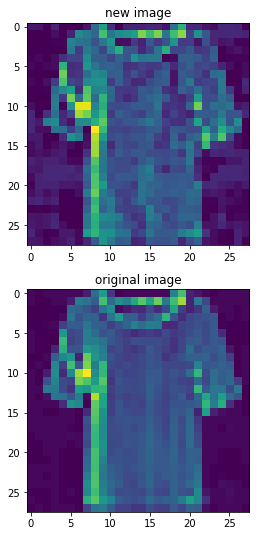

In [68]:
new_image = attacker.gen_adv(x_attack[2],y_attack[2],sess,iterations=10)

In [ ]:
attacker.gen_advs_spe(x_attack,y_attack,sess,iterations=1)#非常耗时